## Abstract
By running the basic two-regime HMM model on both daily and weekly log return data, I found that the model can classified the Russell 3000 time series data into two regimes -- high-return-low-variance state and low-return-high-variance state. Moreover, the coefficents are mostly statistically significant and consistent with other emprical studies. It turns out that three-regime HMM models suffers from convergence issues due to the misspecification of the model. This issue may be resolved by including other dependent variables.


To generate label with three states, I attach a bear label when the probability of low-return state is above certain threshold and label the bull state when the probability of high-return state is above certain threshold. The remaining are static state. 


The classification (labeling) is effective. If I employ a simple trading strategy on the label set (bear -> sell; static -> no position; bull -> buy), the cumulative return is three times higher than buy-and-hold strategy on the testing set. Thus, the label generated from the basic two-regime HMM model is appropriate to train a supervised learning model. I demonstrate in this work that the DNN model generates approxminately three times return than does the buy-and hold strategy.


To predict the future state, I rely on the assumption that the state is more likely to continue than to switch, justifying using the current state to estimate the next state. Note that the diagnal entries of the estimated transition matrix dominates other entries, supporting the above assumption. If we employ the simple trading strategy, the result is somewhat worse than buy-and-hold strategy, confirming the fact that predicting the future state is rather challenging. However, the basic two-regime HMM model does provide practical value if we aim to marginally improve the buy-and-hold strategy. The idea is that we stay with buy-and hold strategy most of the time and deviate only when the model is certain that it is the low-return state. 

Lastly, the analysis on weekly data adds little value to our task. It's no surprise that the predictive power of the label drops dramatically after I shift the label a week. 

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_satrt = '2010-01-01'
train_end = '2018-01-01'

In [ ]:
df=pd.read_csv('gdrive/My Drive/Russell3000.csv',header=0, index_col=0, 
               infer_datetime_format=True, parse_dates=['Date'])
df['log_ret'] = np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(1))
df = df.dropna()
df_train, df_test = df[train_satrt:train_end],df[train_end:'2020-12-31']
df_train

,Open,High,Low,Close,Adj Close,Volume,log_ret
Date,,,,,,,
2010-01-04,653.109985,664.440002,653.109985,664.049988,664.049988,0,0.016581
2010-01-05,664.049988,666.159973,661.909973,665.969971,665.969971,0,0.002887
2010-01-06,665.719971,667.729980,664.880005,666.549988,666.549988,0,0.000871
2010-01-07,666.520020,669.710022,662.969971,669.340027,669.340027,0,0.004177
2010-01-08,669.340027,671.640015,666.159973,671.489990,671.489990,0,0.003207
...,...,...,...,...,...,...,...
2017-12-22,1589.069946,1589.699951,1585.420044,1588.250000,1588.250000,0,-0.000491
2017-12-26,1587.520020,1588.300049,1585.630005,1587.000000,1587.000000,0,-0.000787
2017-12-27,1587.189941,1590.280029,1586.300049,1588.160034,1588.160034,0,0.000731


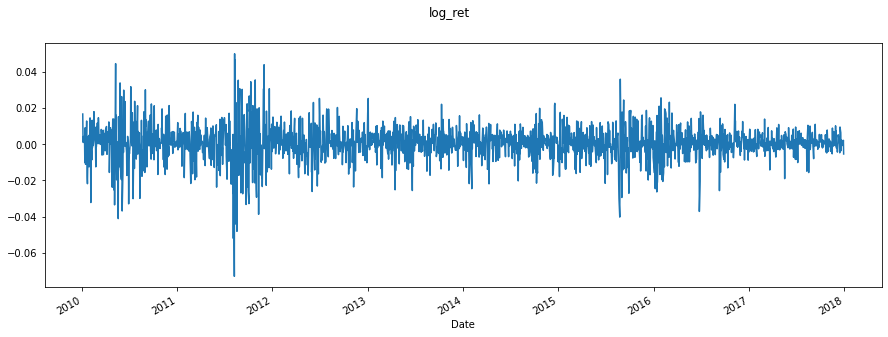

In [ ]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('log_ret')
df_train['log_ret'].plot()
plt.show()

## Two regimes, switching mean and variance on daily data

In [ ]:
hmm_basic1 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm_basic1_results = hmm_basic1.fit(search_reps = 100)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
print(hmm_basic1_results.summary())

                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 2013
Model:               MarkovRegression   Log Likelihood                6805.314
Date:                Sun, 30 Jan 2022   AIC                         -13598.627
Time:                        03:23:47   BIC                         -13564.983
Sample:                             0   HQIC                        -13586.278
                               - 2013                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -1.233      0.218      -0.002       0.000
sigma2         0.0002   1.38e-05     14.924      0.0

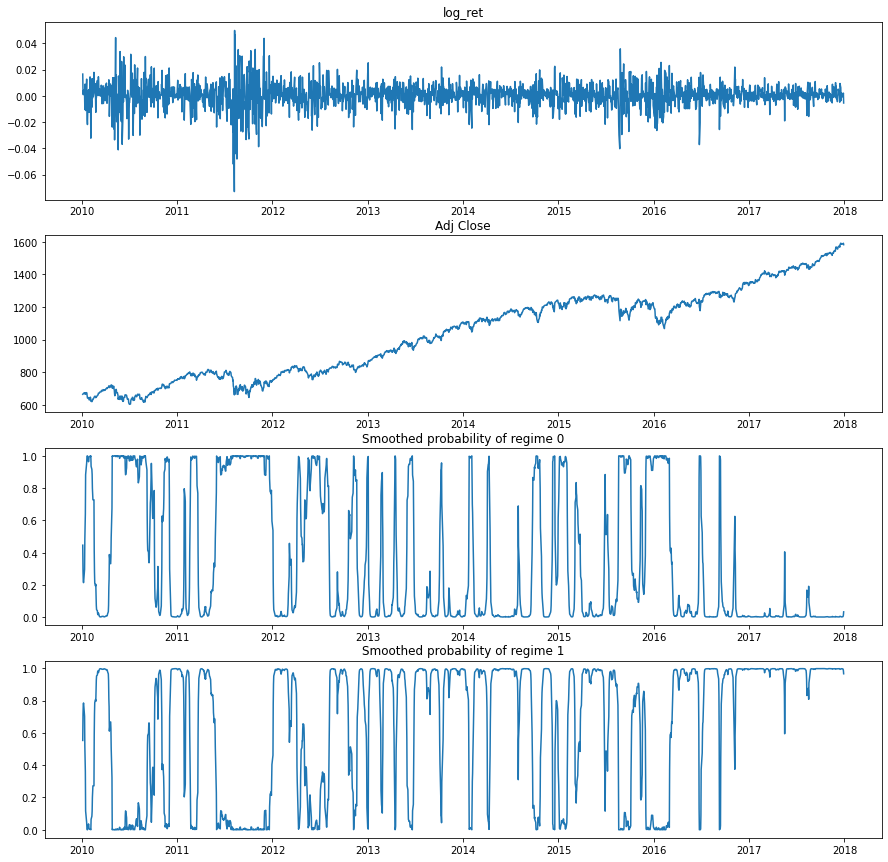

In [ ]:
fig, axes = plt.subplots(4, figsize=(15, 15))
ax = axes[0]
ax.plot(df_train.index, df_train['log_ret'])
ax.set(title='log_ret')

ax = axes[1]
ax.plot(df_train.index, df_train['Adj Close'])
ax.set(title='Adj Close')
 
ax = axes[2]
ax.plot(df_train.index, hmm_basic1_results.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of regime 0')
 
ax = axes[3]
ax.plot(df_train.index, hmm_basic1_results.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of regime 1')

plt.show()

In [ ]:
hmm_basic1_test = sm.tsa.MarkovRegression(endog=df_test['log_ret'], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm_basic1_results_test = hmm_basic1_test.fit(start_params = hmm_basic1_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


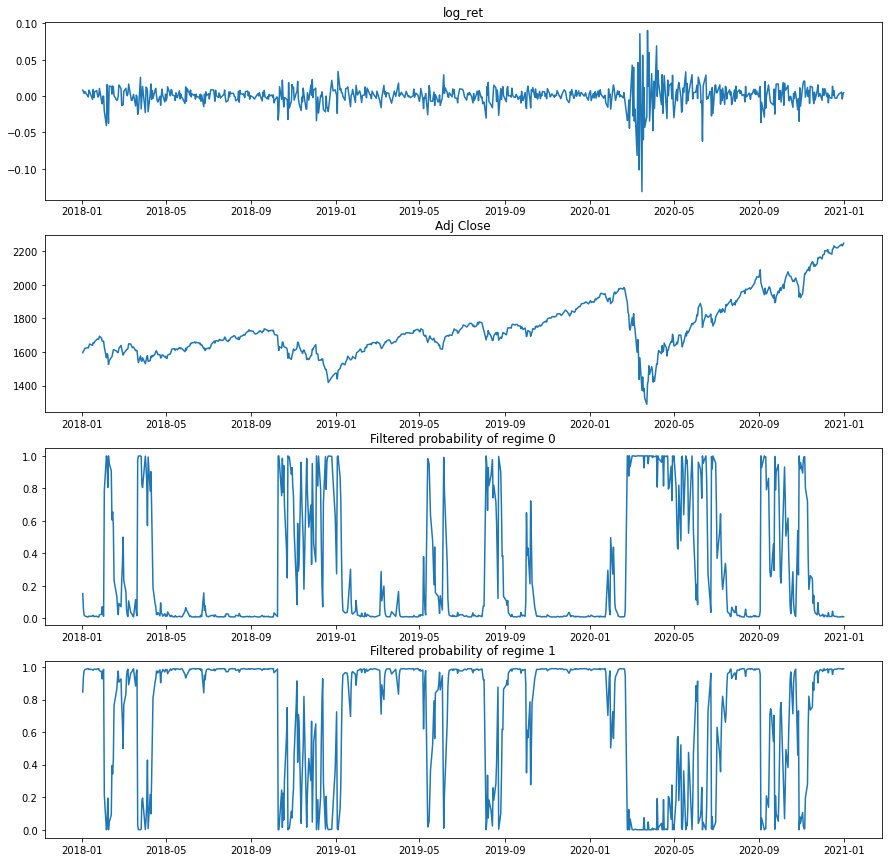

In [ ]:
fig, axes = plt.subplots(4, figsize=(15, 15))
ax = axes[0]
ax.plot(df_test.index, df_test['log_ret'])
ax.set(title='log_ret')

ax = axes[1]
ax.plot(df_test.index, df_test['Adj Close'])
ax.set(title='Adj Close')
 
ax = axes[2]
ax.plot(df_test.index, hmm_basic1_results_test.filtered_marginal_probabilities[0])
ax.set(title='Filtered probability of regime 0')
#ax.plot(df_recession_test.index, df_recession_test['JHDUSRGDPBR'])
#ax.set(title='Smoothed probability of regime 0 super-imposed on GDP based recession indicator (Orange)')

ax = axes[3]
ax.plot(df_test.index, hmm_basic1_results_test.filtered_marginal_probabilities[1])
ax.set(title='Filtered probability of regime 1' )

plt.show()

In [ ]:
# Labeling on the test set
bear_regime = 0 if hmm_basic1_results.params[2]<hmm_basic1_results.params[3] else 1
threshold = 0.8
test_label_daily = []
for i in hmm_basic1_results_test.filtered_marginal_probabilities[bear_regime].values:
  if i >= threshold:
    app = -1
  elif i >= 1-threshold:
    app = 0
  else:
    app = 1
  test_label_daily.append(app)

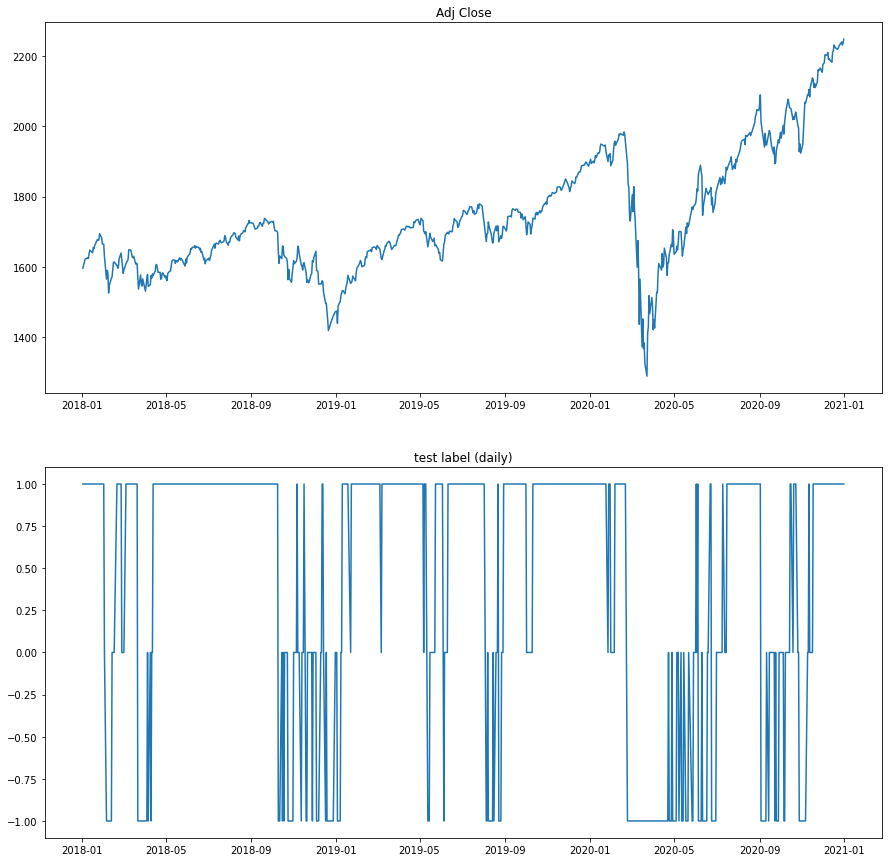

In [ ]:
fig, axes = plt.subplots(2, figsize=(15, 15))

ax = axes[0]
ax.plot(df_test.index, df_test['Adj Close'])
ax.set(title='Adj Close')
 
ax = axes[1]
ax.plot(df_test.index, test_label_daily)
ax.set(title='test label (daily)')
#ax.plot(df_recession_test.index, df_recession_test['JHDUSRGDPBR'])
#ax.set(title='Smoothed probability of regime 0 super-imposed on GDP based recession indicator (Orange)')

plt.show()

## Preliminary Test with customized trading strategy (asymmetric)

In [ ]:
df_test['log_ret'].sum()

0.3510601274199683

In [ ]:
# Effectiveness of the labeling
test_label_daily = np.array(test_label_daily)
(df_test['log_ret'] * test_label_daily).sum()

1.0187345048298182

In [ ]:
# Test with customized trading strategy (asymmetric)
threshold = 0.98
test_label_daily = [0,]
for i in hmm_basic1_results_test.filtered_marginal_probabilities[bear_regime].values:
  if i >= threshold:
    app = -1
  elif i >= 0.8:
    app = 0
  else:
    app = 1
  test_label_daily.append(app)
del test_label_daily[-1]
test_label_daily = np.array(test_label_daily)
(df_test['log_ret'] * test_label_daily).sum()


0.40634076445123934

## Two regimes, switching mean and variance on weekly data

In [ ]:
df=pd.read_csv('gdrive/My Drive/Russell3000.csv',header=0, index_col=0, 
               infer_datetime_format=True, parse_dates=['Date'])
df = df.resample('W').apply('last')
df['log_ret'] = np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(1))
df = df.dropna()
df_train_weekly, df_test_weekly = df[train_satrt:train_end],df[train_end:'2020-12-31']
df_train_weekly

,Open,High,Low,Close,Adj Close,Volume,log_ret
Date,,,,,,,
2010-01-03,659.960022,660.679993,653.000000,653.130005,653.130005,0,-0.011130
2010-01-10,669.340027,671.640015,666.159973,671.489990,671.489990,0,0.027723
2010-01-17,673.130005,673.130005,662.950012,665.669983,665.669983,0,-0.008705
2010-01-24,654.909973,654.909973,639.770020,640.750000,640.750000,0,-0.038155
2010-01-31,635.599976,642.729980,627.739990,628.989990,628.989990,0,-0.018524
...,...,...,...,...,...,...,...
2017-12-03,1568.150024,1570.489990,1543.160034,1565.880005,1565.880005,0,0.014233
2017-12-10,1563.010010,1570.020020,1563.010010,1569.359985,1569.359985,0,0.002220
2017-12-17,1568.900024,1584.780029,1568.900024,1582.079956,1582.079956,0,0.008073


In [ ]:
hmm_basic2 = sm.tsa.MarkovRegression(endog=df_train_weekly['log_ret'], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm_basic2_results = hmm_basic2.fit(search_reps = 100)

In [ ]:
print(hmm_basic2_results.summary())

                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                  418
Model:               MarkovRegression   Log Likelihood                1096.363
Date:                Sun, 30 Jan 2022   AIC                          -2180.726
Time:                        03:23:54   BIC                          -2156.513
Sample:                    01-03-2010   HQIC                         -2171.154
                         - 12-31-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      4.523      0.000       0.002       0.005
sigma2         0.0002   2.07e-05      9.068      0.0

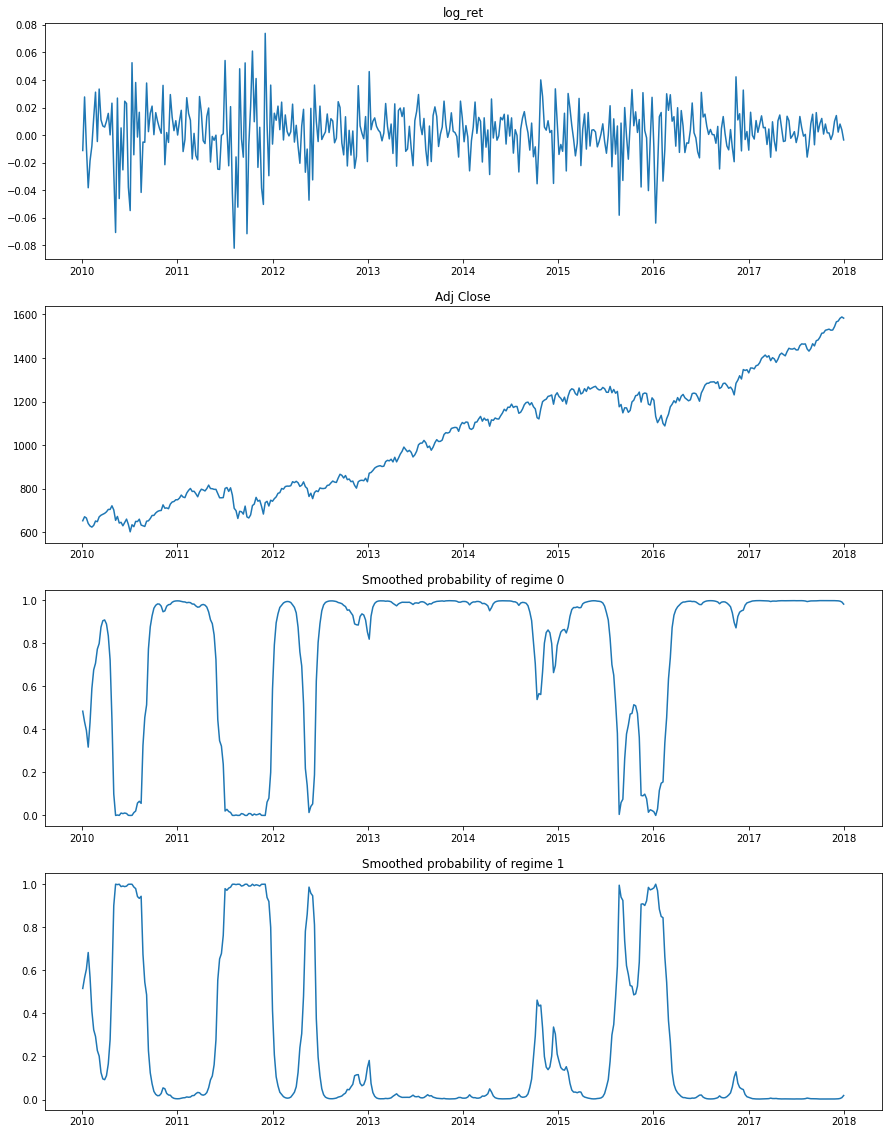

In [ ]:
fig, axes = plt.subplots(4, figsize=(15, 20))
ax = axes[0]
ax.plot(df_train_weekly.index, df_train_weekly['log_ret'])
ax.set(title='log_ret')

ax = axes[1]
ax.plot(df_train_weekly.index, df_train_weekly['Adj Close'])
ax.set(title='Adj Close')
 
ax = axes[2]
ax.plot(df_train_weekly.index, hmm_basic2_results.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of regime 0')

ax = axes[3]
ax.plot(df_train_weekly.index, hmm_basic2_results.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of regime 1')
#ax.plot(df_recession_train.index, df_recession_train['JHDUSRGDPBR'])
#ax.set(title='Smoothed probability of regime 1 super-imposed on GDP based recession indicator (Orange)')

plt.show()

In [ ]:
hmm_basic2_test = sm.tsa.MarkovRegression(endog=df_test_weekly['log_ret'], k_regimes=2,trend='c',
                                    switching_variance=True)
hmm_basic2_results_test = hmm_basic2_test.fit(start_params = hmm_basic2_results.params, maxiter = 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


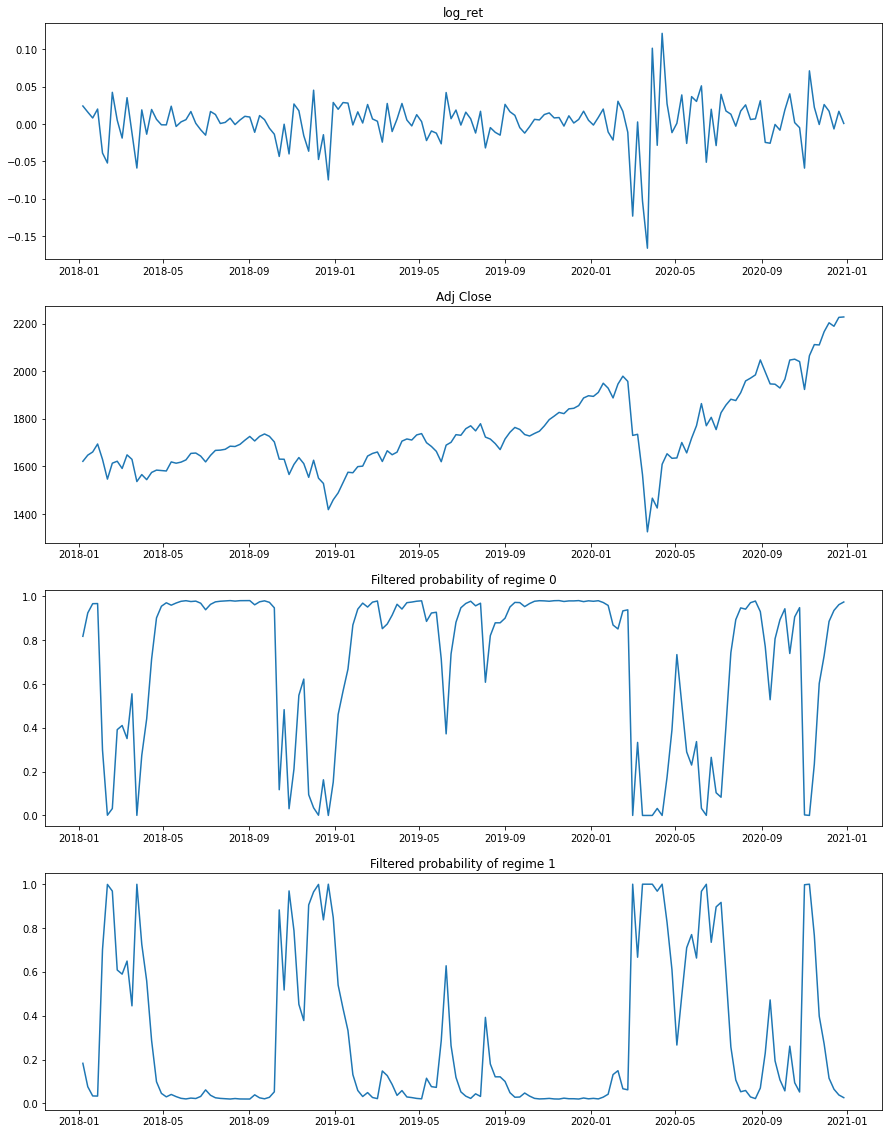

In [ ]:
fig, axes = plt.subplots(4, figsize=(15, 20))
ax = axes[0]
ax.plot(df_test_weekly.index, df_test_weekly['log_ret'])
ax.set(title='log_ret')

ax = axes[1]
ax.plot(df_test_weekly.index, df_test_weekly['Adj Close'])
ax.set(title='Adj Close')
 
ax = axes[2]
ax.plot(df_test_weekly.index, hmm_basic2_results_test.filtered_marginal_probabilities[0])
ax.set(title='Filtered probability of regime 0')

ax = axes[3]
ax.plot(df_test_weekly.index, hmm_basic2_results_test.filtered_marginal_probabilities[1])
ax.set(title='Filtered probability of regime 1')
#ax.plot(df_recession_test.index, df_recession_test['JHDUSRGDPBR'])
#ax.set(title='Smoothed probability of regime 1 super-imposed on GDP based recession indicator (Orange)')

plt.show()

In [ ]:
# Labeling on the test set
bear_regime = 0 if hmm_basic2_results.params[2]<hmm_basic2_results.params[3] else 1
threshold = 0.8
test_label_weekly = []
for i in hmm_basic2_results_test.filtered_marginal_probabilities[bear_regime].values:
  if i >= threshold:
    app = -1
  elif i >= 1-threshold:
    app = 0
  else:
    app = 1
  test_label_weekly.append(app)

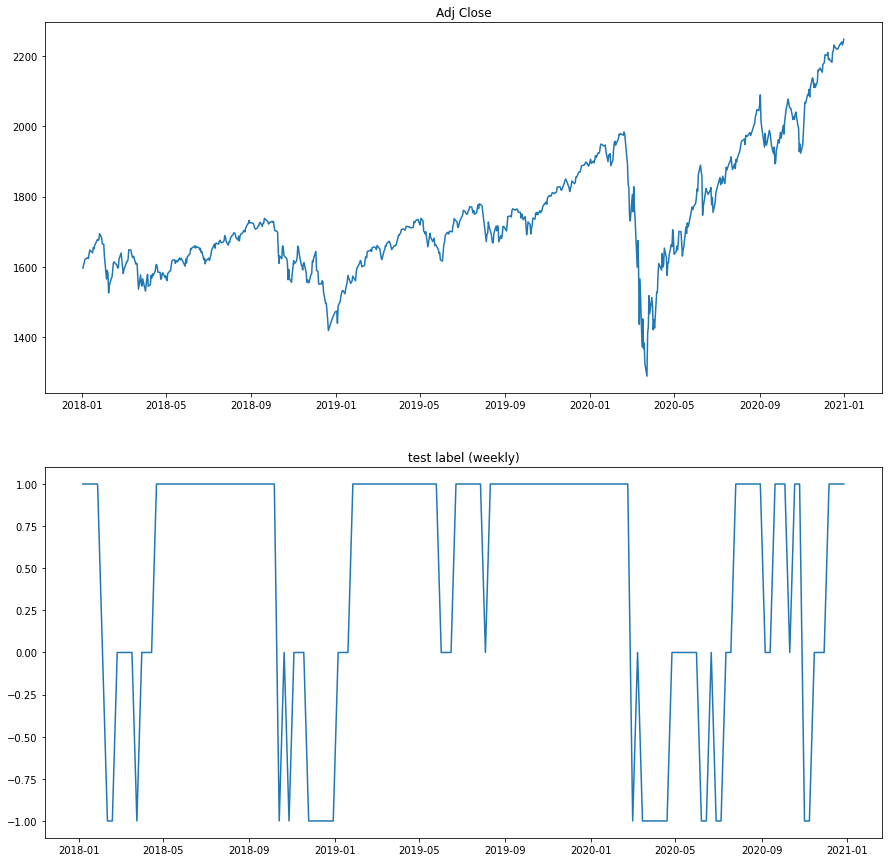

In [ ]:
fig, axes = plt.subplots(2, figsize=(15, 15))

ax = axes[0]
ax.plot(df_test.index, df_test['Adj Close'])
ax.set(title='Adj Close')
 
ax = axes[1]
ax.plot(df_test_weekly.index, test_label_weekly)
ax.set(title='test label (weekly)')
#ax.plot(df_recession_test.index, df_recession_test['JHDUSRGDPBR'])
#ax.set(title='Smoothed probability of regime 0 super-imposed on GDP based recession indicator (Orange)')

plt.show()

## preliminary test with customized trading strategy (asymmetric)

In [ ]:
df_test_weekly['log_ret'].sum()

0.3422105053867579

In [ ]:
test_label_weekly = np.array(test_label_weekly)
(df_test_weekly['log_ret'] * test_label_weekly).sum()

0.8931080142368186

In [ ]:
bear_regime = 0 if hmm_basic2_results.params[2]<hmm_basic2_results.params[3] else 1
threshold = 0.98
test_label_weekly = [0,]
for i in hmm_basic2_results_test.filtered_marginal_probabilities[bear_regime].values:
  if i >= threshold:
    app = -1
  elif i >= 0.9:
    app = 0
  else:
    app = 1
  test_label_weekly.append(app)
del test_label_weekly[-1]
test_label_weekly = np.array(test_label_weekly)
(df_test_weekly['log_ret'] * test_label_weekly).sum()


-0.04972591663385906

In [ ]:
hmm_basic3 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=3,trend='c',
                                    switching_variance=True)
hmm_basic3_results = hmm_basic3.fit(search_reps = 100,search_scale=0.01)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
print(hmm_basic3_results.summary())

                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 2013
Model:               MarkovRegression   Log Likelihood                6864.880
Date:                Sun, 30 Jan 2022   AIC                         -13705.761
Time:                        03:24:14   BIC                         -13638.472
Sample:                             0   HQIC                        -13681.062
                               - 2013                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      6.357      0.000       0.001       0.002
sigma2      1.895e-05    2.6e-06      7.276      0.0

In [ ]:
# Labeling on the training set
bear_regime = 0 if hmm_basic1_results.params[2]<hmm_basic1_results.params[3] else 1
threshold = 0.8
train_label_daily = []
for i in hmm_basic1_results.filtered_marginal_probabilities[bear_regime].values:
  if i >= threshold:
    app = 0
  elif i >= 1-threshold:
    app = 1
  else:
    app = 2
  train_label_daily.append(app)
train_label_daily= np.array(train_label_daily,dtype = 'uint8')
df_train['state'] = train_label_daily
df_train

,Open,High,Low,Close,Adj Close,Volume,log_ret,state
Date,,,,,,,,
2010-01-04,653.109985,664.440002,653.109985,664.049988,664.049988,0,0.016581,0
2010-01-05,664.049988,666.159973,661.909973,665.969971,665.969971,0,0.002887,1
2010-01-06,665.719971,667.729980,664.880005,666.549988,666.549988,0,0.000871,1
2010-01-07,666.520020,669.710022,662.969971,669.340027,669.340027,0,0.004177,2
2010-01-08,669.340027,671.640015,666.159973,671.489990,671.489990,0,0.003207,2
...,...,...,...,...,...,...,...,...
2017-12-22,1589.069946,1589.699951,1585.420044,1588.250000,1588.250000,0,-0.000491,2
2017-12-26,1587.520020,1588.300049,1585.630005,1587.000000,1587.000000,0,-0.000787,2
2017-12-27,1587.189941,1590.280029,1586.300049,1588.160034,1588.160034,0,0.000731,2


In [ ]:
# Labeling on the testing set
bear_regime = 0 if hmm_basic1_results.params[2]<hmm_basic1_results.params[3] else 1
threshold = 0.8
test_label_daily = []
for i in hmm_basic1_results_test.filtered_marginal_probabilities[bear_regime].values:
  if i >= threshold:
    app = 0
  elif i >= 1-threshold:
    app = 1
  else:
    app = 2
  test_label_daily.append(app)
test_label_daily= np.array(test_label_daily,dtype='uint8')
df_test['state'] = test_label_daily
df_test

,Open,High,Low,Close,Adj Close,Volume,log_ret,state
Date,,,,,,,,
2018-01-02,1585.089966,1595.939941,1585.089966,1595.869995,1595.869995,0,0.008243,2
2018-01-03,1595.839966,1605.890015,1595.839966,1605.189941,1605.189941,0,0.005823,2
2018-01-04,1605.699951,1613.839966,1605.699951,1611.020020,1611.020020,0,0.003625,2
2018-01-05,1612.140015,1621.479980,1612.140015,1621.369995,1621.369995,0,0.006404,2
2018-01-08,1621.280029,1624.780029,1617.640015,1624.349976,1624.349976,0,0.001836,2
...,...,...,...,...,...,...,...,...
2020-12-24,2226.149902,2229.050049,2220.989990,2228.629883,2228.629883,1923800,0.002687,2
2020-12-28,2234.790039,2246.139893,2234.790039,2240.850098,2240.850098,0,0.005468,2
2020-12-29,2241.850098,2252.760010,2228.590088,2232.010010,2232.010010,0,-0.003953,2


## RNN with HMM label

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [ ]:
df_train

,Open,High,Low,Close,Adj Close,Volume,log_ret,state
Date,,,,,,,,
2010-01-04,653.109985,664.440002,653.109985,664.049988,664.049988,0,0.016581,0
2010-01-05,664.049988,666.159973,661.909973,665.969971,665.969971,0,0.002887,1
2010-01-06,665.719971,667.729980,664.880005,666.549988,666.549988,0,0.000871,1
2010-01-07,666.520020,669.710022,662.969971,669.340027,669.340027,0,0.004177,2
2010-01-08,669.340027,671.640015,666.159973,671.489990,671.489990,0,0.003207,2
...,...,...,...,...,...,...,...,...
2017-12-22,1589.069946,1589.699951,1585.420044,1588.250000,1588.250000,0,-0.000491,2
2017-12-26,1587.520020,1588.300049,1585.630005,1587.000000,1587.000000,0,-0.000787,2
2017-12-27,1587.189941,1590.280029,1586.300049,1588.160034,1588.160034,0,0.000731,2


In [ ]:
# Separate the target value — the "label"— from the features. 
# This label is the value that you will train the model to predict.
train_features = df_train[['Open','High','Low','Adj Close','log_ret','state']].copy()
test_features = df_test[['Open','High','Low','Adj Close','log_ret','state']].copy()

train_labels = train_features['state'].shift(-1)
test_labels = test_features['state'].shift(-1)

In [ ]:
train_features = train_features[:-1]
test_features = test_features[:-1]
train_labels = train_labels.dropna()
test_labels = test_labels.dropna()

In [ ]:
len(train_features)

2012

In [ ]:
len(train_labels)

2012

In [ ]:
train_labels = np.array(train_labels,dtype = 'uint8')
test_labels = np.array(test_labels,dtype = 'uint8')
train_labels

array([1, 1, 2, ..., 2, 2, 2], dtype=uint8)

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [ ]:
normalizer.adapt(np.array(train_features))

In [50]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(3)
  ])

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(0.0001),metrics=['accuracy'])
  return model

In [51]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 32)                224       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,392
Trainable params: 1,379
Non-trainable params: 13
_________________________________________________________________


In [52]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,verbose=1, epochs=250)

Epoch 1/250
51/51 [==============================] - 1s 10ms/step - loss: 1.0821 - accuracy: 0.3667 - val_loss: 0.7197 - val_accuracy: 0.8933
Epoch 2/250
51/51 [==============================] - 0s 6ms/step - loss: 1.0515 - accuracy: 0.4512 - val_loss: 0.6558 - val_accuracy: 0.8933
Epoch 3/250
51/51 [==============================] - 0s 6ms/step - loss: 1.0222 - accuracy: 0.5333 - val_loss: 0.5945 - val_accuracy: 0.8983
Epoch 4/250
51/51 [==============================] - 0s 5ms/step - loss: 0.9931 - accuracy: 0.6165 - val_loss: 0.5379 - val_accuracy: 0.9082
Epoch 5/250
51/51 [==============================] - 0s 5ms/step - loss: 0.9633 - accuracy: 0.6501 - val_loss: 0.4864 - val_accuracy: 0.9132
Epoch 6/250
51/51 [==============================] - 0s 6ms/step - loss: 0.9320 - accuracy: 0.6675 - val_loss: 0.4440 - val_accuracy: 0.9156
Epoch 7/250
51/51 [==============================] - 0s 6ms/step - loss: 0.9009 - accuracy: 0.6799 - val_loss: 0.4068 - val_accuracy: 0.9156
Epoch 8/250


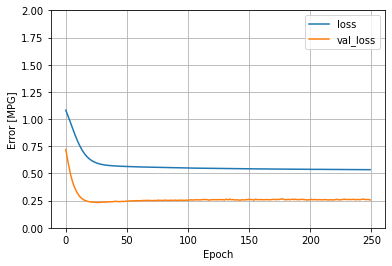

In [53]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [54]:
test_loss, test_acc = dnn_model.evaluate(test_features,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

23/23 - 0s - loss: 0.5541 - accuracy: 0.7967 - 52ms/epoch - 2ms/step

Test accuracy: 0.7967032790184021


In [55]:
probability_model = tf.keras.Sequential([dnn_model, 
                                         tf.keras.layers.Softmax()])

In [56]:
predictions = probability_model.predict(test_features)
predictions[0]

array([0.00706889, 0.07328322, 0.91964793], dtype=float32)

In [57]:
test_label_dnn = [1,]
for i in predictions:
  if i[0]> max(i[1],i[2]):
    test_label_dnn.append(-1)
  elif i[1]> max(i[0],i[2]):
    test_label_dnn.append(0)
  else:
    test_label_dnn.append(1)

test_label_dnn = np.array(test_label_dnn)
(df_test['log_ret'] * test_label_daily).sum()

1.3697946322497865

In [58]:
df_test['log_ret'].sum()

0.3510601274199683